In [147]:
"""
Created By    : Clay Wooton
Creation Date : 31 October 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #02 - Successive Corrections

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using successive corrections.

Through the use of Cressman analysis, three successive iterations of
observations were used to improve the accuracy and detail of the
first pass. Each subsequent pass used the prior pass as the background. 

Additionally, these three passes were compared through simple differencing 
as well as calculating the root mean square differences of each pass. 

"""
__author__    = "Clay Wooton"
__contact__   = "claiborne.wooton@und.edu"

In [148]:
#Import modules

import pandas as pd
import numpy as np               
import matplotlib.pyplot as plt    
import cartopy.crs as ccrs         
import cartopy.feature as cfeature 

In [149]:
#Create function for Cressman analysis

def cressman (d_ik, R):

    if d_ik <= R:
        w = ((R**2)-(d_ik**2)) / ((R**2)+(d_ik**2))
        
    elif d_ik > R:
        w = 0
    
    return w         #Cressman weight function

In [150]:
#Read-in data

data = pd.read_csv("RAOBs_201903131200.txt", delimiter = ',',names = ['Station ID', 'Latitude', 'Longitude', '500-mb Height (m)', '500-mb Wind Direction', '500-mb Wind Speed (kts)'])
df = pd.DataFrame(data)

In [151]:
df

,Station ID,Latitude,Longitude,500-mb Height (m),500-mb Wind Direction,500-mb Wind Speed (kts)
0,CWPL,51.47,-90.2,5460.0,285.0,29.0
1,CWQI,43.83,-66.0,5540.0,325.0,41.0
2,CWSE,53.55,-113.9,5360.0,280.0,12.0
3,CYAH,53.75,-73.6,5340.0,300.0,70.0
4,CYBK,64.30,-96.0,5220.0,95.0,17.0
...,...,...,...,...,...,...
130,KWAL,37.93,-75.4,5730.0,325.0,44.0
131,KXKF,32.37,-64.6,5620.0,300.0,46.0
132,KYAK,59.52,-139.6,5340.0,195.0,22.0
133,KYMW,46.38,-75.9,5580.0,275.0,38.0


In [152]:
lat_float = df['Latitude'].astype(float)
lon_float = df['Longitude'].astype(float)
obs_ht = df['500-mb Height (m)'].astype(float)
obs_ht = np.array(obs_ht)

In [153]:
#Given Variables

phi_0 = 60                       #Latitude (in degrees)
phi_0_rad = (60/180) * np.pi     #Latitude (in radians)
lam_0 = -115                     #Longitude (in degrees)
lam_0_rad = (-115/180) * np.pi   #Longitude in degrees
e_rad = 637100000                #Radius of Earth (in cm)
map_s = 1/15000000               #Map scale
del_x = 1.27                     #Spacing of points (in cm)
del_y = 1.27                     #Spacing of points (in cm)
x_0 = 18.9                       #(in cm)
y_0 = -6.3                       #(in cm)

#(x_0,y_0) is the northwest corner of the map 

In [154]:
#Create 22x28 grid 

x_values = x_0 + np.arange(22) * del_x            #22 analysis points on the map (x-direction)
y_values = y_0 + np.arange(28) * del_y            #28 analysis points on the map (y-direction)
grid_x, grid_y = np.meshgrid(x_values, y_values)  #Makes the grid

In [155]:
#Convert x,y values from grid into lat,lon. Equations from Appendix A: The Polar Stereographic Map Projection.

grid_lat = (180 / np.pi) * ((np.pi / 2) - (2 * np.arctan(np.sqrt((grid_x / map_s)**2 + (grid_y / map_s)**2) / (e_rad * (1 + np.sin(phi_0_rad))))))  #Latitude 
grid_lon = np.arctan(grid_y / grid_x) * (180 / np.pi) + lam_0                                                                                       #Longitude

In [156]:
#Convert obs lat,lon to x,y. Equations from Appendix A: The Polar Stereographic Map Projection

sig = ((1 + np.sin(phi_0_rad)) / (1 + np.sin(lat_float * (np.pi / 180)))) 
obs_x = e_rad * sig * np.cos(lat_float * (np.pi / 180)) * np.cos((lon_float * (np.pi / 180)) - lam_0_rad) * map_s
obs_y = e_rad * sig * np.cos(lat_float * (np.pi / 180)) * np.sin((lon_float * (np.pi / 180)) - lam_0_rad) * map_s

#Make obs x,y into an array

obs_x = np.array(obs_x)
obs_y = np.array(obs_y)

In [157]:
#Convert obs x,y to lat,lon

obs_lat = (180 / np.pi) * ((np.pi / 2) - (2 * np.arctan(np.sqrt((obs_x / map_s)**2 + (obs_y / map_s)**2) / (e_rad * (1 + np.sin(phi_0_rad)))))) 
obs_lon = np.arctan(obs_y / obs_x) * (180 / np.pi) + lam_0

In [158]:
#Find dmin

empty_dmin = np.zeros(len(obs_x))

for i in range(135):
    r = ((obs_x[i] - obs_x)**2 + (obs_y[i] - obs_y)**2)**(1/2) #Use the Pythagorean Theorem to find the distance between the observation and the analysis point. 
    r.sort()
    empty_dmin[i] = r[1]               #Call the i = 1 value since calling i = 0 is just the distance between an observation point and itself, i.e., zero.
    
real_dmin = np.mean(empty_dmin)

print(real_dmin)

2.5548700820071417


In [159]:
#Find Radius of Influence

R1 = 4 * real_dmin
R2 = 2.5 * real_dmin
R3 = 1.5 * real_dmin

roi_arr = np.array([R1, R2, R3])

In [160]:
#500mb geopotential height analyses using Cressman weighting function with RoI of 4 *dmin, 2.5 *dmin, 1.5 *dmin

In [161]:
#First Pass

#Empty matrices

x_n = 28                                             #Number of columns
y_n = 22                                             #Number of rows
analysis_matrix = np.zeros((x_n,y_n,len(roi_arr)))

#Create for loop to fill empty matrices

for j in range(len(grid_x)):
    for k in range(len(grid_x[0])):
        x_dist = grid_x[j,k] - obs_x
        y_dist = grid_y[j,k] - obs_y
        radius = ((x_dist)**2 + (y_dist)**2)**(1/2)
        index_roi = np.where(radius <= R1)[0]            #First pass uses RoI = R1
        weights = np.zeros(len(obs_x))
        for i in index_roi:
            w = cressman(radius[i], R1)
            weights[i] = w
        analysis_matrix[j,k,0] = np.sum(weights*obs_ht)/np.sum(weights)       #Equation f_A^1 from instructions. Used to generate background field for subsequent passes

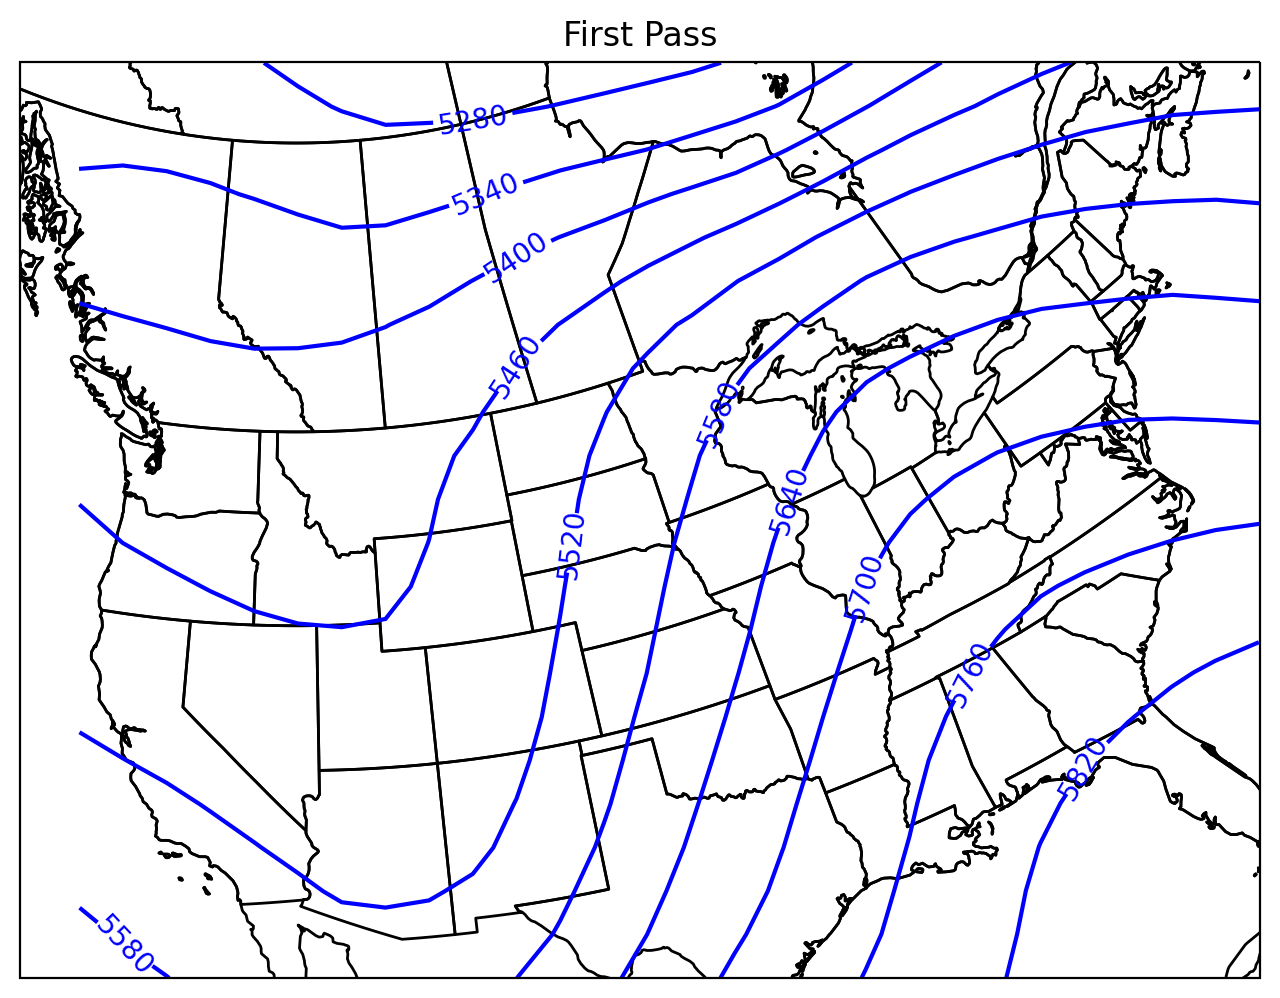

In [162]:
#Plot 500mb geopotential height for first pass, RoI = R1

proj = ccrs.Stereographic(central_longitude = -115.0, central_latitude = 90.0, true_scale_latitude = 60.0)
fig = plt.figure(figsize = (8,8), dpi = 200)
ax1 = fig.add_subplot(111,projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(grid_lon,grid_lat,analysis_matrix[:,:,0],colors='b',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('First Pass')
plt.savefig("First Pass")
plt.show()

In [163]:
#Create function for bilinear interpolation

def bilinear(x, y, RoI):
    
    #Create a generic reference grid box for observation locations to be compared to
    
    rel_x = x - int(np.floor(x))                   
    rel_y = y - int(np.floor(y))                
    
    #Define the coordinates for the generic grid box (x_1, y_1), (x_2, y_1), (x_2, y_2), (x_1, y_2)
    
    x_1 = 0                   
    x_2 = 1
    y_1 = 0
    y_2 = 1

    #Thus, the generic grid box has coordinates (0,0), (1,0), (1,1), (0,1)  
    
    delta_x = x_2 - x_1
    delta_y = y_2 - y_1

    #To identify which grid box a given observation is in:
    
    z_1 = analysis_matrix[int(np.floor(y)), int(np.floor(x)), RoI]     #Upper-left grid point
    z_2 = analysis_matrix[int(np.ceil(y)), int(np.floor(x)), RoI]      #Upper-right grid point
    z_3 = analysis_matrix[int(np.ceil(y)), int(np.ceil(x)), RoI]       #Lower-right grid point
    z_4 = analysis_matrix[int(np.floor(y)), int(np.ceil(x)), RoI]      #Lower-left grid point
    
    #Enter bilinear interpolation function
    
    P = (1 / (delta_x*delta_y)) * ((rel_x - x_2)*(rel_y - y_2)*(z_1) - (rel_x - x_1)*(rel_y - y_2)*(z_2) + (rel_x - x_1)*(rel_y - y_1)*(z_3) - (rel_x - x_2)*(rel_y - y_1)*(z_4))
    
    return P

In [164]:
#Second pass

#Setup for the second pass
ind_x = ((obs_x - x_0)/del_x)              #Used to find the relative x-coordinate of a given observation within a grid box
ind_y = ((obs_y - y_0)/del_y)              #Used to find the relative y-coordinate of a given observation within a grid box

P1 = np.zeros(len(obs_x))                  #Create an empty array for bilinear interpolation

#Use bilinear if the observation is within the grid. If the observation is not within the grid, use a "reverse" Cressman analysis
#Reverse Cressman uses the observation point (instead of the analysis point) as the center point 

for i in range(len(ind_x)):
    if (ind_x[i] >= 0) and (ind_x[i] < 21) and (ind_y[i] >= 0) and (ind_y[i] < 27):      #To only utilize observations within the grid, use bilinear
        p = bilinear(ind_x[i], ind_y[i], 0)                                              #The zero uses the analysis values from the first pass
    else:
        x_dist_r = obs_x[i] - grid_x                        #Observation not in grid, use reverse Cressman
        y_dist_r = obs_y[i] - grid_y                        #Observation not in grid, use reverse Cressman 
        radius_r = ((x_dist_r)**2 + (y_dist_r)**2)**(1/2)
        impt_vals_r = np.where(radius_r <= roi_arr[0])
        weights_r = np.zeros(grid_x.shape)                  #Make the grid
        for j in impt_vals_r[0]:                            #Observations within RoI of R1
            for k in impt_vals_r[1]:                        #Observations within RoI of R1
                weights_cressman_r = cressman(radius_r[j,k], roi_arr[0])
                weights_r[j,k] = weights_cressman_r
        p = np.sum(weights_r * analysis_matrix[:,:,0]) / np.sum(weights_r) #Equation f^1_A from instructions using first pass as the background
       
    P1[i] = p
    
for j in range(len(grid_x)):            #Runs through the length of the x grid
    for k in range(len(grid_x[0])):     #Runs through the values of the x grid
        x_dist = grid_x[j,k] - obs_x    
        y_dist = grid_y[j,k] - obs_y    
        radius = ((x_dist)**2 + (y_dist)**2)**(1/2)     #Pythagoran Theorem to find distance from center
        impt_vals = np.where(radius <= roi_arr[1])[0]   #The observations within the radius of influence
        weights = np.zeros(len(obs_x))
       
        for l in impt_vals:
            w = cressman(radius[l], roi_arr[1])         #Reverse Cressman
            weights[l] = w
        
        analysis_matrix[j,k,1] = analysis_matrix[j,k,0] + (np.nansum(weights*(obs_ht - P1)) / np.nansum(weights)) #Equation f^j_A from instructions gives second pass

/var/folders/6m/5jy3kjwx3bg9cqnkh8mr3j1h0000gn/T/ipykernel_50950/1207173813.py:25: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(weights_r * analysis_matrix[:,:,0]) / np.sum(weights_r) #Equation f^1_A from instructions using first pass as the background


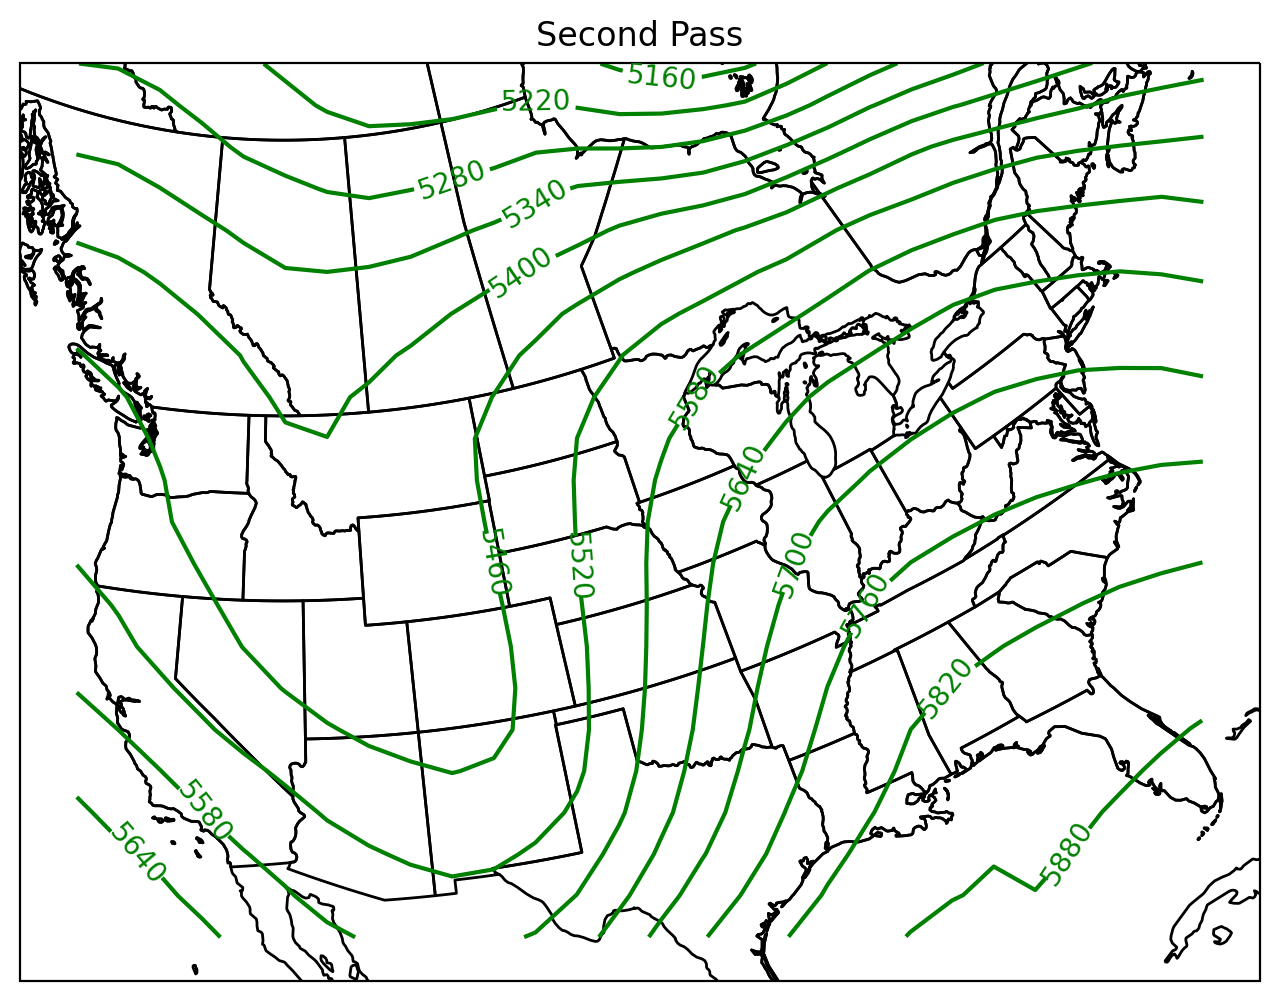

In [165]:
#Plot 500mb geopotential height for second pass, RoI = R2

proj = ccrs.Stereographic(central_longitude = -115.0, central_latitude = 90.0, true_scale_latitude = 60.0)
fig = plt.figure(figsize = (8,8), dpi = 200)
ax1 = fig.add_subplot(111,projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(grid_lon,grid_lat,analysis_matrix[:,:,1],colors='g',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Second Pass')
plt.savefig('Second Pass')
plt.show()

In [166]:
#Third pass

#Setup for the third pass
ind_x = ((obs_x - x_0)/del_x)                  #Used to find the relative x-coordinate of a given observation within a grid box
ind_y = ((obs_y - y_0)/del_y)                  #Used to find the relative y-coordinate of a given observation within a grid box

P2 = np.zeros(len(obs_x))                      #Create an empty array for bilinear interpolation

#Use bilinear if the observation is within the grid. If the observation is not within the grid, use a "reverse" Cressman analysis
#Reverse Cressman uses the observation point (instead of the analysis point) as the center point 

for i in range(len(ind_x)):
    if (ind_x[i] >= 0) and (ind_x[i] < 21) and (ind_y[i] >= 0) and (ind_y[i] < 27):        #To only utilize observations within the grid, use bilinear
        p = bilinear(ind_x[i], ind_y[i], 1)                                                #The 1 uses the analysis values from the second pass
    else:
        x_dist_r = obs_x[i] - grid_x                       #Observation not in grid, use reverse Cressman
        y_dist_r = obs_y[i] - grid_y                       #Observation not in grid, use reverse Cressman 
        radius_r = ((x_dist_r)**2 + (y_dist_r)**2)**(1/2)
        impt_vals_r = np.where(radius_r <= roi_arr[1])
        weights_r = np.zeros(grid_x.shape)                 #Make the grid
        for j in impt_vals_r[0]:                           #Observations within the RoI of R2
            for k in impt_vals_r[1]:                       #Observations within the RoI of R2
                weights_cressman_r = cressman(radius_r[j,k], roi_arr[1]) 
                weights_r[j,k] = weights_cressman_r
        p = np.sum(weights_r * analysis_matrix[:,:,1]) / np.sum(weights_r) #Equation f^1_A from instructions using second pass as the background
       
    P2[i] = p
    
for j in range(len(grid_x)):            #Runs through the length of the x grid
    for k in range(len(grid_x[0])):     #Runs through the values of the x grid
        x_dist = grid_x[j,k] - obs_x 
        y_dist = grid_y[j,k] - obs_y 
        radius = ((x_dist)**2 + (y_dist)**2)**(1/2)       #Pythagoran Theorem to find distance from center
        impt_vals = np.where(radius <= roi_arr[2])[0]     #The observations within the radius of influence
        weights = np.zeros(len(obs_x))
       
        for l in impt_vals:
            w = cressman(radius[l], roi_arr[2])           #Reverse Cressman
            weights[l] = w
       
        analysis_matrix[j,k,2] = analysis_matrix[j,k,1] + (np.nansum(weights*(obs_ht - P2)) / np.nansum(weights)) #Equation f^j_A from instructions gives third pass

/var/folders/6m/5jy3kjwx3bg9cqnkh8mr3j1h0000gn/T/ipykernel_50950/335903781.py:25: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(weights_r * analysis_matrix[:,:,1]) / np.sum(weights_r) #Equation f^1_A from instructions using second pass as the background
/var/folders/6m/5jy3kjwx3bg9cqnkh8mr3j1h0000gn/T/ipykernel_50950/335903781.py:41: RuntimeWarning: invalid value encountered in double_scalars
  analysis_matrix[j,k,2] = analysis_matrix[j,k,1] + (np.nansum(weights*(obs_ht - P2)) / np.nansum(weights)) #Equation f^j_A from instructions gives third pass


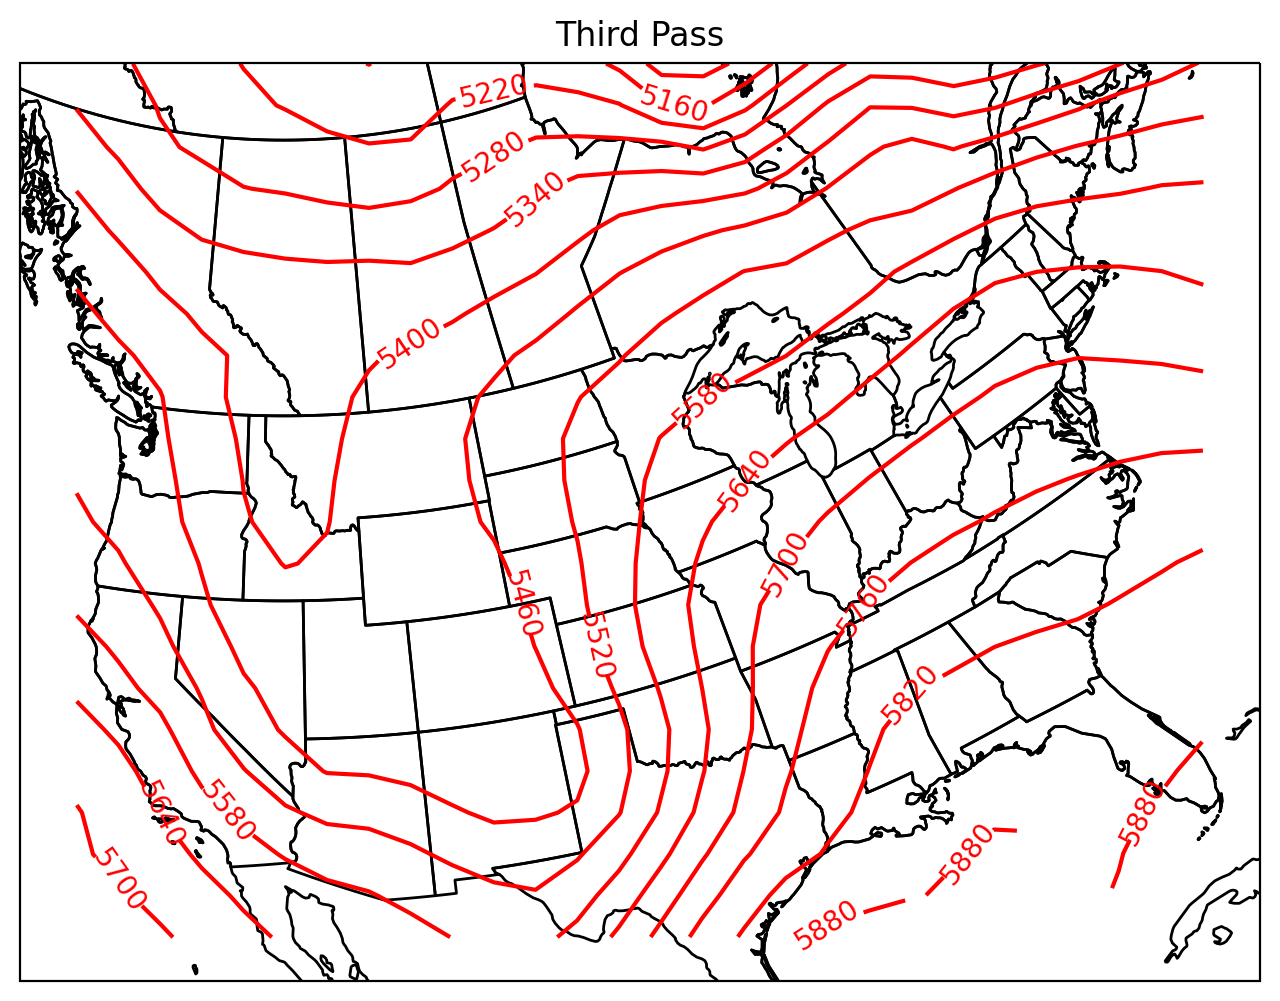

In [167]:
#Plot 500mb geopotential height for third pass, RoI = R3

proj = ccrs.Stereographic(central_longitude = -115.0, central_latitude = 90.0, true_scale_latitude = 60.0)
fig = plt.figure(figsize = (8,8), dpi = 200)
ax1 = fig.add_subplot(111,projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(grid_lon,grid_lat,analysis_matrix[:,:,2],colors='r',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Third Pass')
plt.savefig('Third Pass')
plt.show()

In [168]:
#Compute differences between analyses

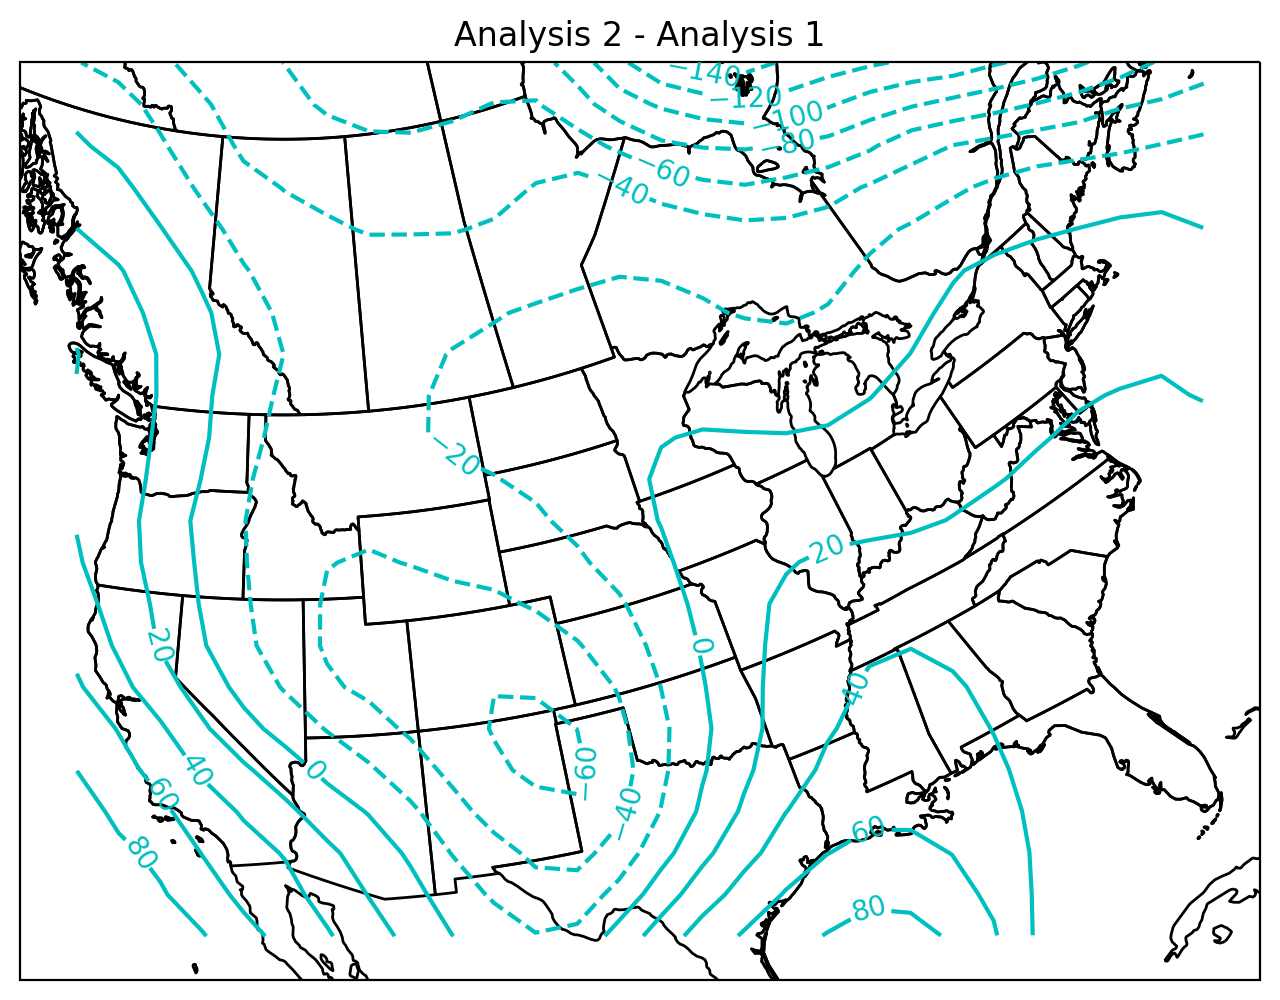

In [169]:
#Analysis 2 - Analysis 1

A_2_1 = analysis_matrix[:,:,1] - analysis_matrix[:,:,0]

proj = ccrs.Stereographic(central_longitude = -115.0, central_latitude = 90.0, true_scale_latitude = 60.0)
fig = plt.figure(figsize = (8,8), dpi = 200)
ax1 = fig.add_subplot(111,projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(grid_lon,grid_lat,A_2_1,colors='c',levels=np.arange(-8000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,20))
plt.title('Analysis 2 - Analysis 1')
plt.savefig('Analysis 2 - Analysis 1')
plt.show()

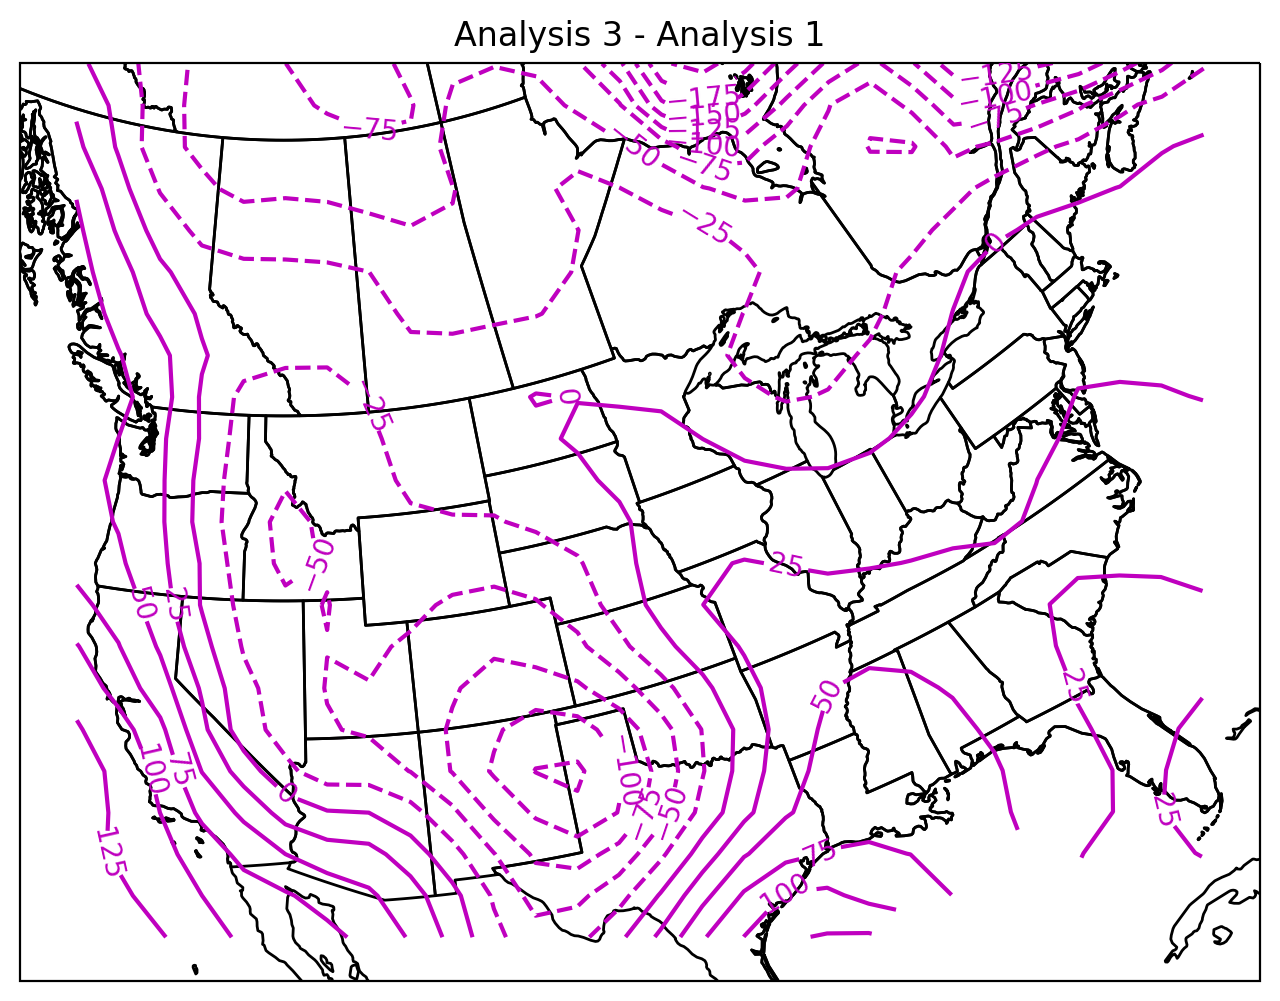

In [170]:
#Analysis 3 - Analysis 1

A_3_1 = analysis_matrix[:,:,2] - analysis_matrix[:,:,0]

proj = ccrs.Stereographic(central_longitude = -115.0, central_latitude = 90.0, true_scale_latitude = 60.0)
fig = plt.figure(figsize = (8,8), dpi = 200)
ax1 = fig.add_subplot(111,projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(grid_lon,grid_lat,A_3_1,colors='m',levels=np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,25))
plt.title('Analysis 3 - Analysis 1')
plt.savefig('Analysis 3 - Analysis 1')
plt.show()

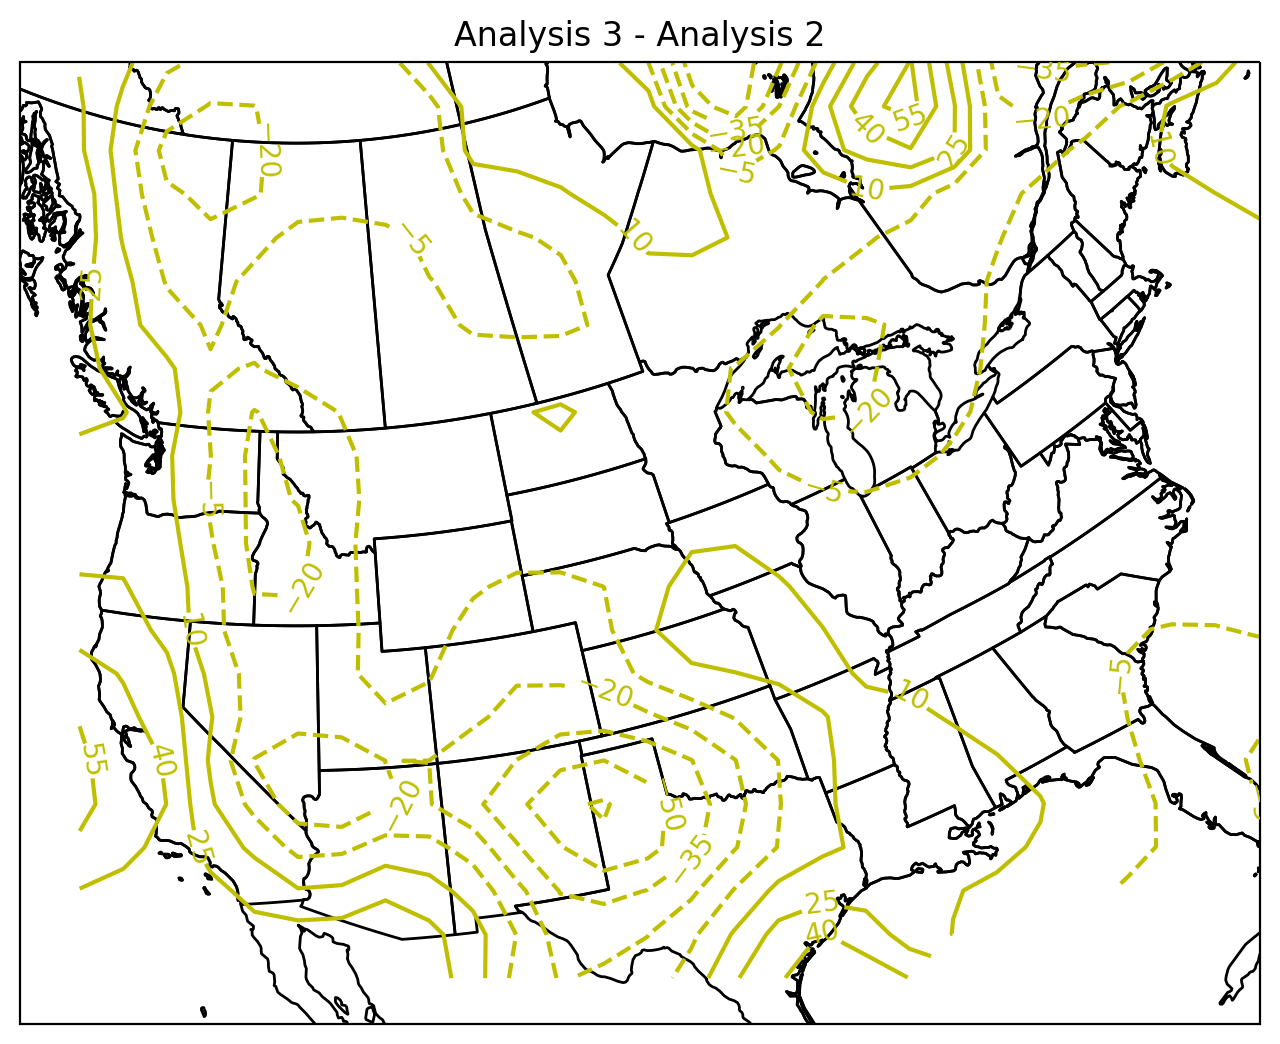

In [171]:
#Analysis 3 - Analysis 2

A_3_2 = analysis_matrix[:,:,2] - analysis_matrix[:,:,1]

proj = ccrs.Stereographic(central_longitude = -115.0, central_latitude = 90.0, true_scale_latitude = 60.0)
fig = plt.figure(figsize = (8,8), dpi = 200)
ax1 = fig.add_subplot(111,projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(grid_lon,grid_lat,A_3_2,colors='y',levels=np.arange(-8000,8000,15),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,15))
plt.title('Analysis 3 - Analysis 2')
plt.savefig('Analysis 3 - Analysis 2')
plt.show()

In [172]:
#Compute the root mean square differences between the analyses and observations for each analysis pass

#Calculate P3 for use within the root mean square equation for third pass

ind_x = ((obs_x - x_0)/del_x)            #Used to find the relative x-coordinate of a given observation within a grid box
ind_y = ((obs_y - y_0)/del_y)            #Used to find the relative y-coordinate of a given observation within a grid box

P3 = np.zeros(len(obs_x))                #Create an empty array for bilinear interpolation

#Use bilinear if the observation is within the grid. If the observation is not within the grid, use a "reverse" Cressman analysis
#Reverse Cressman uses the observation point (instead of the analysis point) as the center point 

for i in range(len(ind_x)):
    if (ind_x[i] >= 0) and (ind_x[i] < 21) and (ind_y[i] >= 0) and (ind_y[i] < 27):   #To only utilize observations within the grid, use bilinear
        p = bilinear(ind_x[i], ind_y[i], 2)                                           #The 2 uses the analysis values from the third pass
    else:
        x_dist_r = obs_x[i] - grid_x                        #Observation not in grid, use reverse Cressman
        y_dist_r = obs_y[i] - grid_y                        #Observation not in grid, use reverse Cressman 
        radius_r = ((x_dist_r)**2 + (y_dist_r)**2)**(1/2)
        impt_vals_r = np.where(radius_r <= roi_arr[2])
        weights_r = np.zeros(grid_x.shape)                  #Make the grid
        for j in impt_vals_r[0]:                            #Observations within the RoI of R3
            for k in impt_vals_r[1]:                        #Observations within the RoI of R3
                weights_cressman_r = cressman(radius_r[j,k], roi_arr[2])
                weights_r[j,k] = weights_cressman_r
        p = np.sum(weights_r * analysis_matrix[:,:,2]) / np.sum(weights_r)     #Equation f^1_A from instructions using third pass as the background
       
    P3[i] = p  

In [173]:
#Use equation deltaj_rms from instructions for root mean square calculation

#Root mean square for first pass

diff_1 = (obs_ht - P1)**2
diff_1 = diff_1[~np.isnan(diff_1)]                 #Removes nan values from dataset
rms_1 = np.sqrt((np.sum(diff_1)) / len(diff_1))    #len(diff_1) gives the updated total number of observations (K)

#Root mean square for second pass

diff_2 = (obs_ht - P2)**2
diff_2 = diff_2[~np.isnan(diff_2)]                 #Removes nan values from dataset
rms_2 = np.sqrt((np.sum(diff_2)) / len(diff_2))    #len(diff_2) gives the updated total number of observations (K)

#Root mean square for third pass

diff_3 = (obs_ht - P3)**2
diff_3 = diff_3[~np.isnan(diff_3)]                 #Removes nan values from dataset
rms_3 = np.sqrt((np.sum(diff_3)) / len(diff_3))    #len(diff_3) gives the updated total number of observations (K)

rms_list = list([rms_1, rms_2, rms_3])

print(rms_list)

[74.54329800402631, 35.12766126581702, 11.681749880587397]


In [174]:
#Store analyses in text files

a_file = open("Analysis_Matrix_RoI_4dmin", "w")
for line in analysis_matrix[:,:,0]:
    np.savetxt(a_file, line)
    
b_file = open("Analysis_Matrix_RoI_2.5dmin", "w")
for line in analysis_matrix[:,:,1]:
    np.savetxt(b_file, line)
    
c_file = open("Analysis_Matrix_RoI_1.5dmin", "w")
for line in analysis_matrix[:,:,2]:
    np.savetxt(c_file, line)

In [177]:
#Store the difference fields in text files

d_file = open("A_2_1", "w")
for line in A_2_1:
    np.savetxt(d_file, line)
    
e_file = open("A_3_1", "w")
for line in A_3_1:
    np.savetxt(e_file, line)
    
f_file = open("A_3_2", "w")
for line in A_3_2:
    np.savetxt(f_file, line)

In [178]:
#Store RMS values in text file

np.savetxt("RMS_values.txt", rms_list)